<a href="https://www.kaggle.com/code/bbernoturbiz/customyolov5?scriptVersionId=92750294" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# P7 OpenClassrooms - Develop a proof of concept

<p>Pour ce projet, j'ai voulu aller plus loin en Computer Vision, et passer de la classification d'images à l'Object Detection, avec un modèle "State-of-the-art", à savoir YOLO v5.</p>
<p> J'ai choisi un dataset sur la santé des plantes. C'est un sujet assez éloigné des cas usuels de détection COCO

Développé sur Kaggle avec Yolov5 - https://www.kaggle.com/ultralytics/yolov5

Dataset public (https://public.roboflow.com/object-detection/plantdoc) récupéré depuis [Roboflow](https://roboflow.com), un outil de gestion de dataset et annotation d'images, entre autres.
- *Overview: <br><p>The PlantDoc dataset was originally published by researchers at the Indian Institute of Technology, and described in depth in their [paper](https://arxiv.org/pdf/1911.10317.pdf). One of the paper’s authors, Pratik Kayal, shared the object detection dataset available on [GitHub](https://github.com/pratikkayal/PlantDoc-Dataset).<br>PlantDoc is a dataset of 2,569 images across 13 plant species and 30 classes (diseased and healthy) for image classification and object detection. There are 8,851 labels.</p>*
- Dataset resized to 416*416

In [1]:
########################################
## False for a normal training run
## True to use a previously saved run (stored on WeTransfer)
dl_weights_from_previous_run = False

# if True we need some previous weights. Here is a link to my so far best backup run
wetransfer_link = "https://wetransfer.com/downloads/1c30f1d7780c95c565a1675f17a2276220220304223406/fca5a4a4af727dd59f51b3441101567b20220304223406/3b46c7"

# else train with settings:

# Freeze YOLOv5 
# 24 = full freeze, 10 = partial freeze, None = no freeze      --- more about freeze: https://github.com/ultralytics/yolov5/issues/1314
FREEZE = None 

EPOCHS = 100

# 1. Setup

Clone repo, install dependencies and check PyTorch and GPU.

In [2]:
#!git clone https://github.com/ultralytics/yolov5  # clone
# issue with latest release, temporary using older branch
!git clone --branch classifier https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12789, done.
remote: Total 12789 (delta 0), reused 0 (delta 0), pack-reused 12789
Receiving objects: 100% (12789/12789), 11.82 MiB | 22.09 MiB/s, done.
Resolving deltas: 100% (8894/8894), done.
/kaggle/working/yolov5
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

# pour que display fonctionne dans un bloc
get_ipython().ast_node_interactivity = 'all'



YOLOv5 🚀 v6.1-211-gfa2c16a torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 3293.3/4030.7 GB disk)


## Suivi des résultats

Il sont récupérés par [Weights & Biases](https://wandb.ai/site?utm_campaign=repo_yolo_notebook) (W&B)
- [Consulter les résultats](https://wandb.ai/bber/YOLOv5/reports/P7-Object-Detection--VmlldzoxNjQ1ODY2)
(les tout derniers résultats sont consultables via le lien donné dans l'output du training. ATTENTION, il faut parfoit corriger l'url fournie ("< span>" final à effacer))

In [4]:
# Keep W&B key secret - Set it in Kaggle Add-ons "Secrets"
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandbkey")

In [5]:
# Weights & Biases
%pip install -q wandb
import wandb

wandb.login(key=wandb_key)

### uncomment for only local (no recording with W&B):
!wandb offline

Note: you may need to restart the kernel to use updated packages.


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

W&B offline, running your script from this directory will only write metadata locally.


### Utility

In [6]:
import os
import re

## utils funcs for "natural order" sort (need it to get current exp# directory created by w&b)
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# get last run dir 'exp#' from tvd: train, val, or detect runs
def get_last_exp(tvd):
    return sorted(os.listdir('runs/'+tvd), key=natural_keys)[-1]  

# 2. Dataset

Yolov5 nécessite un format particulier pour le dataset annoté avec bounding box: "Yolov5 PyTorch"

Roboflow propose l'export de ce Dataset public sous ce format, parmis d'autres. Trois tailles d'images sont disponibles, on a exporté les images en 416*416

In [7]:
IMG_SIZE = 416

# Download zipped Dataset from Roboflow, unzip and suppress zip file
!curl -L --progress-bar "https://public.roboflow.com/ds/MJdP1IEG7h?key=6Q4WWXcKh1" > roboflow.zip; unzip -qn roboflow.zip; rm roboflow.zip

######################################################################### 100.0%


In [8]:
# mv dataset to expected location, rename config file, and rename test to valid (data.yaml created by Roboflow has wrong path)
!mv data.yaml data/plantDoc.yaml
!mv train ..
!mv test ../valid

In [9]:
## TODO extract it from data/plantDoc.yaml   # easier, copy/paste from output of 
## !more data/plantDoc.yaml
labels = ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf spot', 'Bell_pepper leaf', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Potato leaf', 'Raspberry leaf', 'Soyabean leaf', 'Soybean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato leaf', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf black rot', 'grape leaf']

# 3. Train

Train a YOLOv5s (Yolov5 "Small") model on the [PlantDoc](https://public.roboflow.com/object-detection/plantdoc) dataset with `--data plantDoc.yaml`, starting from pretrained `--weights yolov5s.pt`

- **Pretrained [Models](https://github.com/ultralytics/yolov5/tree/master/models)** are downloaded
automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases)
- **Training Results** are saved to `runs/train/` with incrementing run directories, i.e. `runs/train/exp2`, `runs/train/exp3` etc.
<br><br>

In [10]:
best_weights = None
if dl_weights_from_previous_run:
    # get weights from previous runs (I have a copy of best result weights on WeTransfer)
    !git clone https://github.com/iamleot/transferwee  # clone
    !python transferwee/transferwee.py download -o custom_weights.pt {wetransfer_link}
    best_weights = 'custom_weights.pt'
else:
    # Train YOLOv5s on PlantDoc
    if FREEZE is not None:
        !python train.py --img {IMG_SIZE} --batch 32 --epochs {EPOCHS} --data plantDoc.yaml --weights yolov5s.pt --cache --freeze {FREEZE}
    else:
        !python train.py --img {IMG_SIZE} --batch 32 --epochs {EPOCHS} --data plantDoc.yaml --weights yolov5s.pt --cache
    best_weights = 'runs/train/'+get_last_exp('train')+'/weights/best.pt'

train: weights=yolov5s.pt, cfg=, data=plantDoc.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 9 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-211-gfa2c16a torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv

## Train results

* Run en cours *
exp
* Resultats générés par train.py *
F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1649706569.f3eac00fc377.113.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


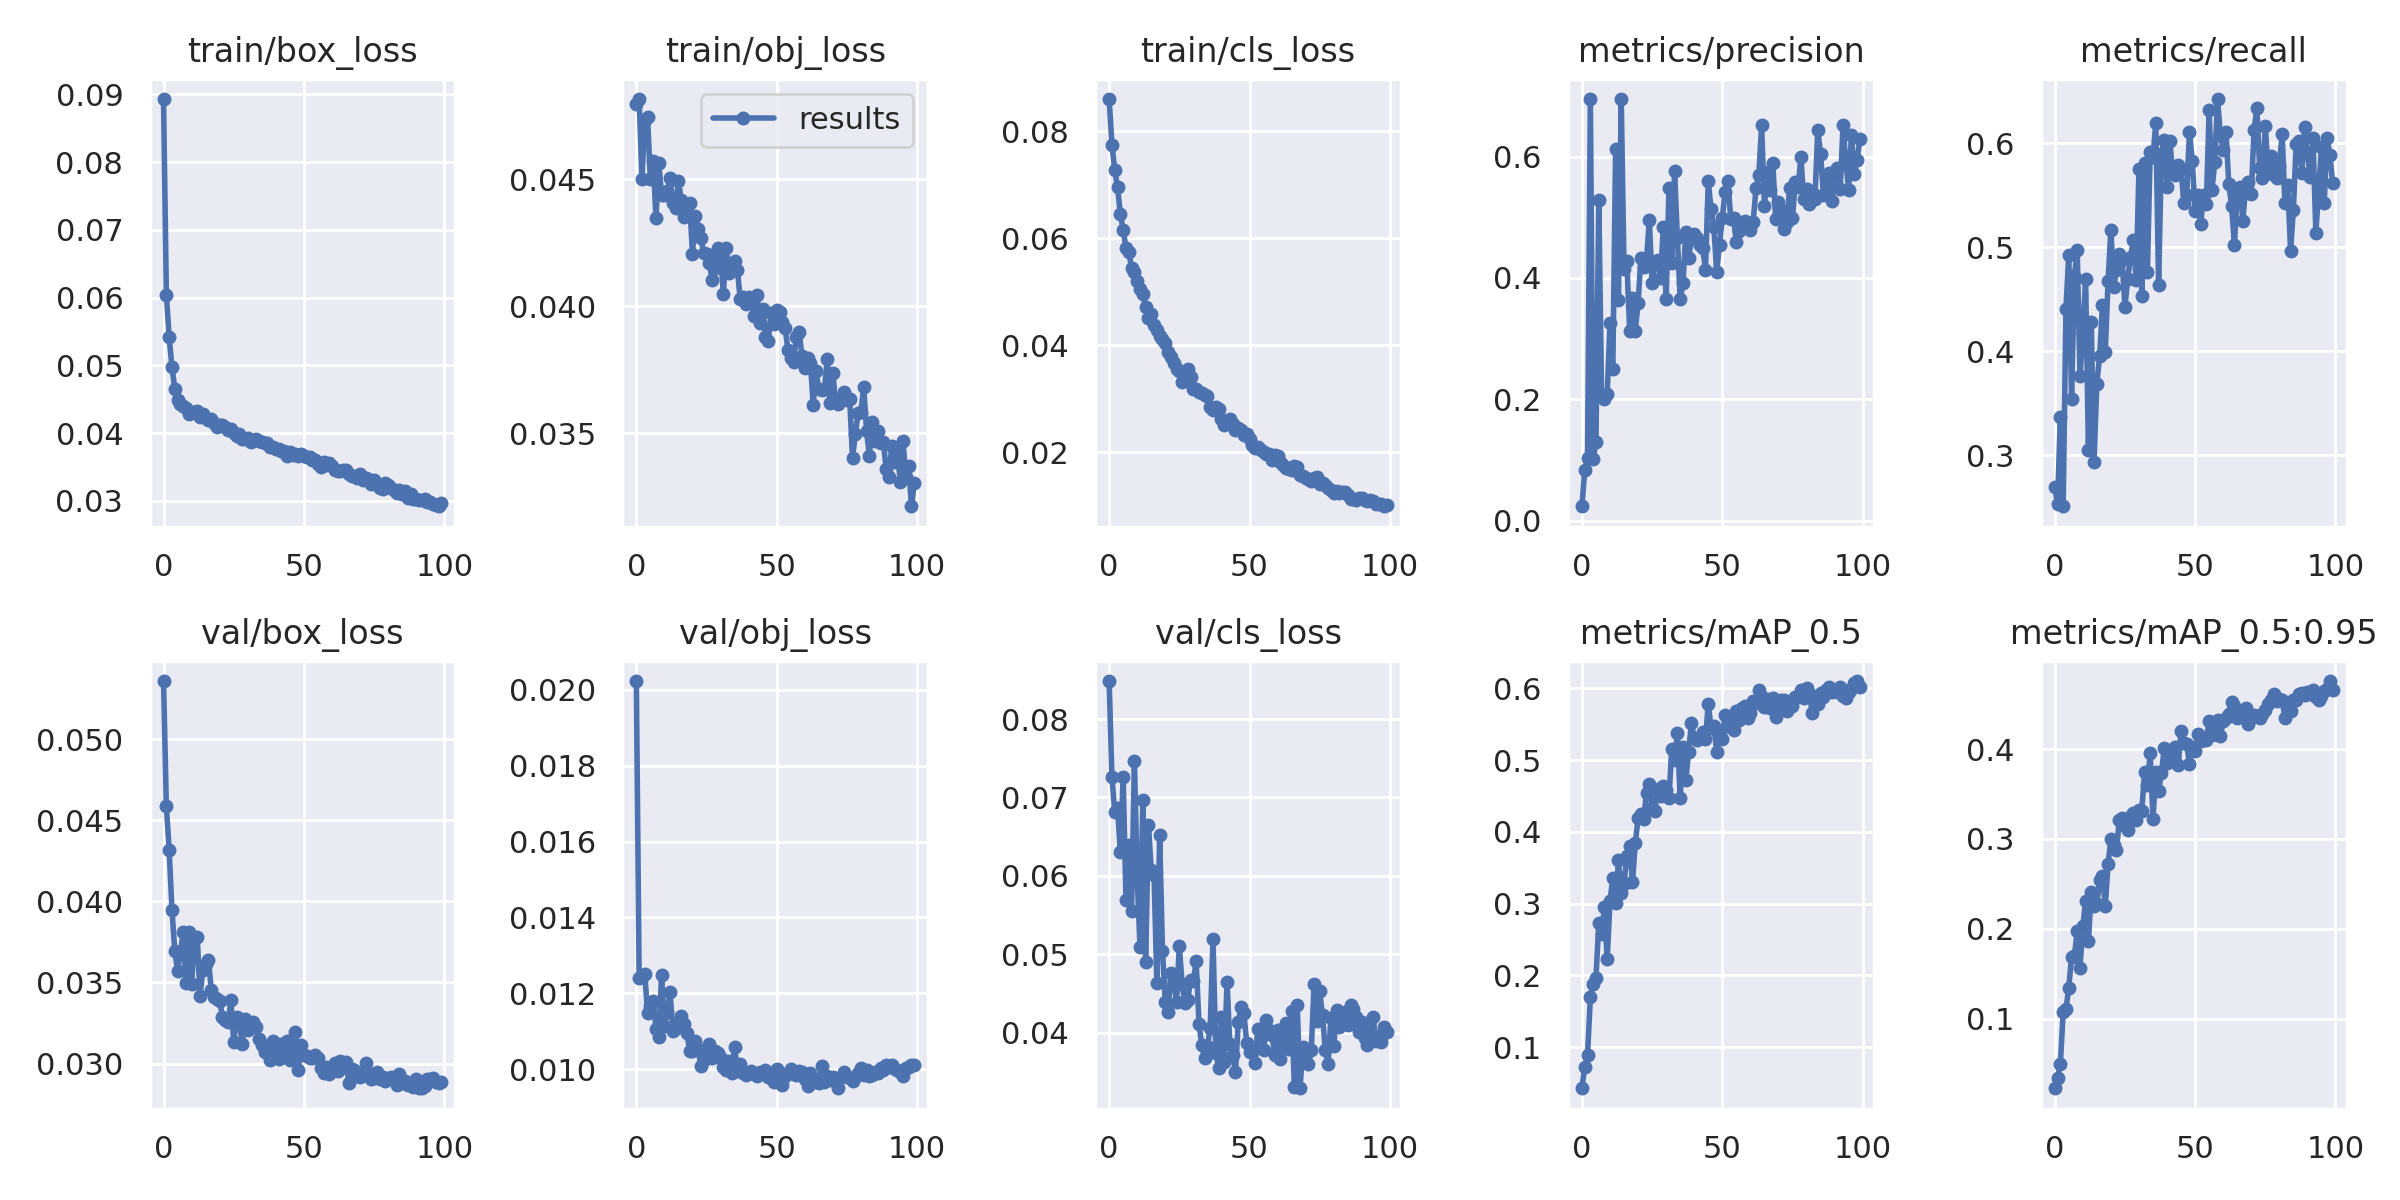

In [11]:
try:
    exp = get_last_exp('train')
    print("* Run en cours *")
    print(exp)
    print("* Resultats générés par train.py *")
    !ls runs/train/{exp}
    display.Image(filename='runs/train/'+exp+'/results.png')
except:
    print("No training or result file missing")

# 4. Validation

In [12]:
!python val.py --weights {best_weights} --data data/plantDoc.yaml --img {IMG_SIZE} --save-conf --conf 0.4 --iou 0.50      # mAP

val: data=data/plantDoc.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.4, iou_thres=0.5, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-211-gfa2c16a torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7091035 parameters, 0 gradients, 16.1 GFLOPs
val: Scanning '/kaggle/working/yolov5/../valid/labels.cache' images and labels..
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        239        454      0.645      0.551       0.61      0.502
     Apple Scab Leaf        239         13      0.661      0.769      0.782      0.649
          Apple leaf        239         10      0.507        0.7      0.773      0.599
     Apple rust leaf        239         11      0.926      0.545

In [13]:
### apercu des resultats produits 
exp = get_last_exp('val')
print("* Run en cours *")
print(exp)
print("* Resultats générés par val.py *")
!ls runs/val/{exp}

* Run en cours *
exp
* Resultats générés par val.py *
F1_curve.png  confusion_matrix.png   val_batch1_pred.jpg
PR_curve.png  val_batch0_labels.jpg  val_batch2_labels.jpg
P_curve.png   val_batch0_pred.jpg    val_batch2_pred.jpg
R_curve.png   val_batch1_labels.jpg


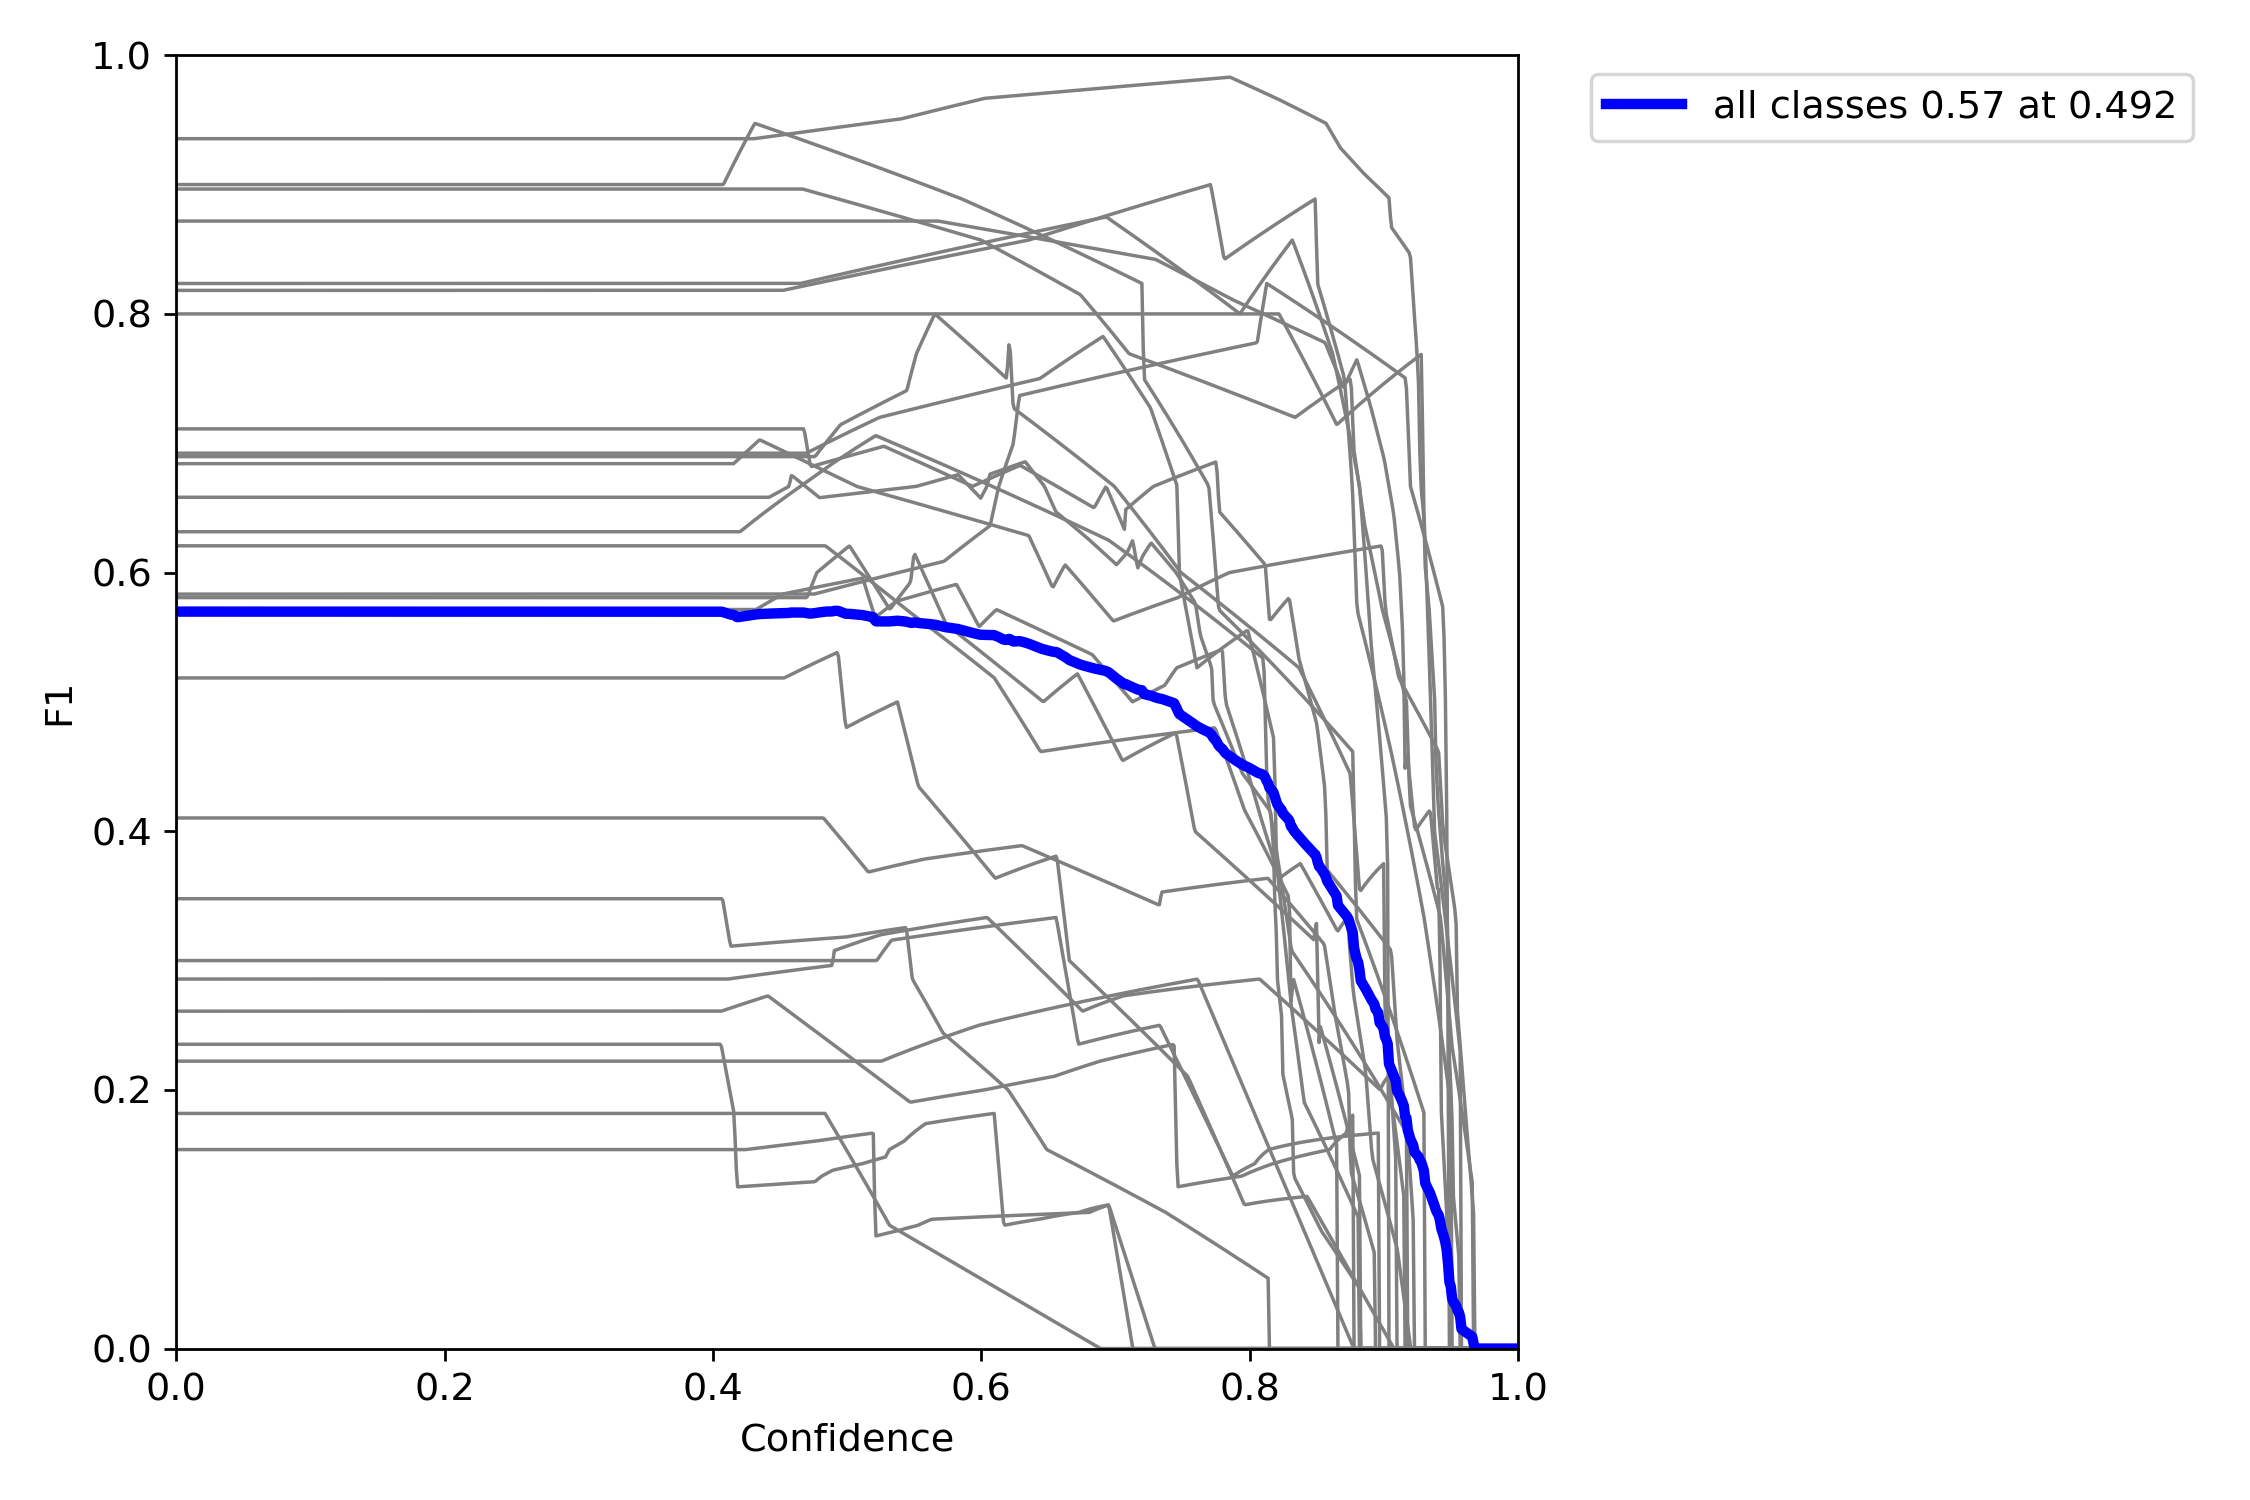

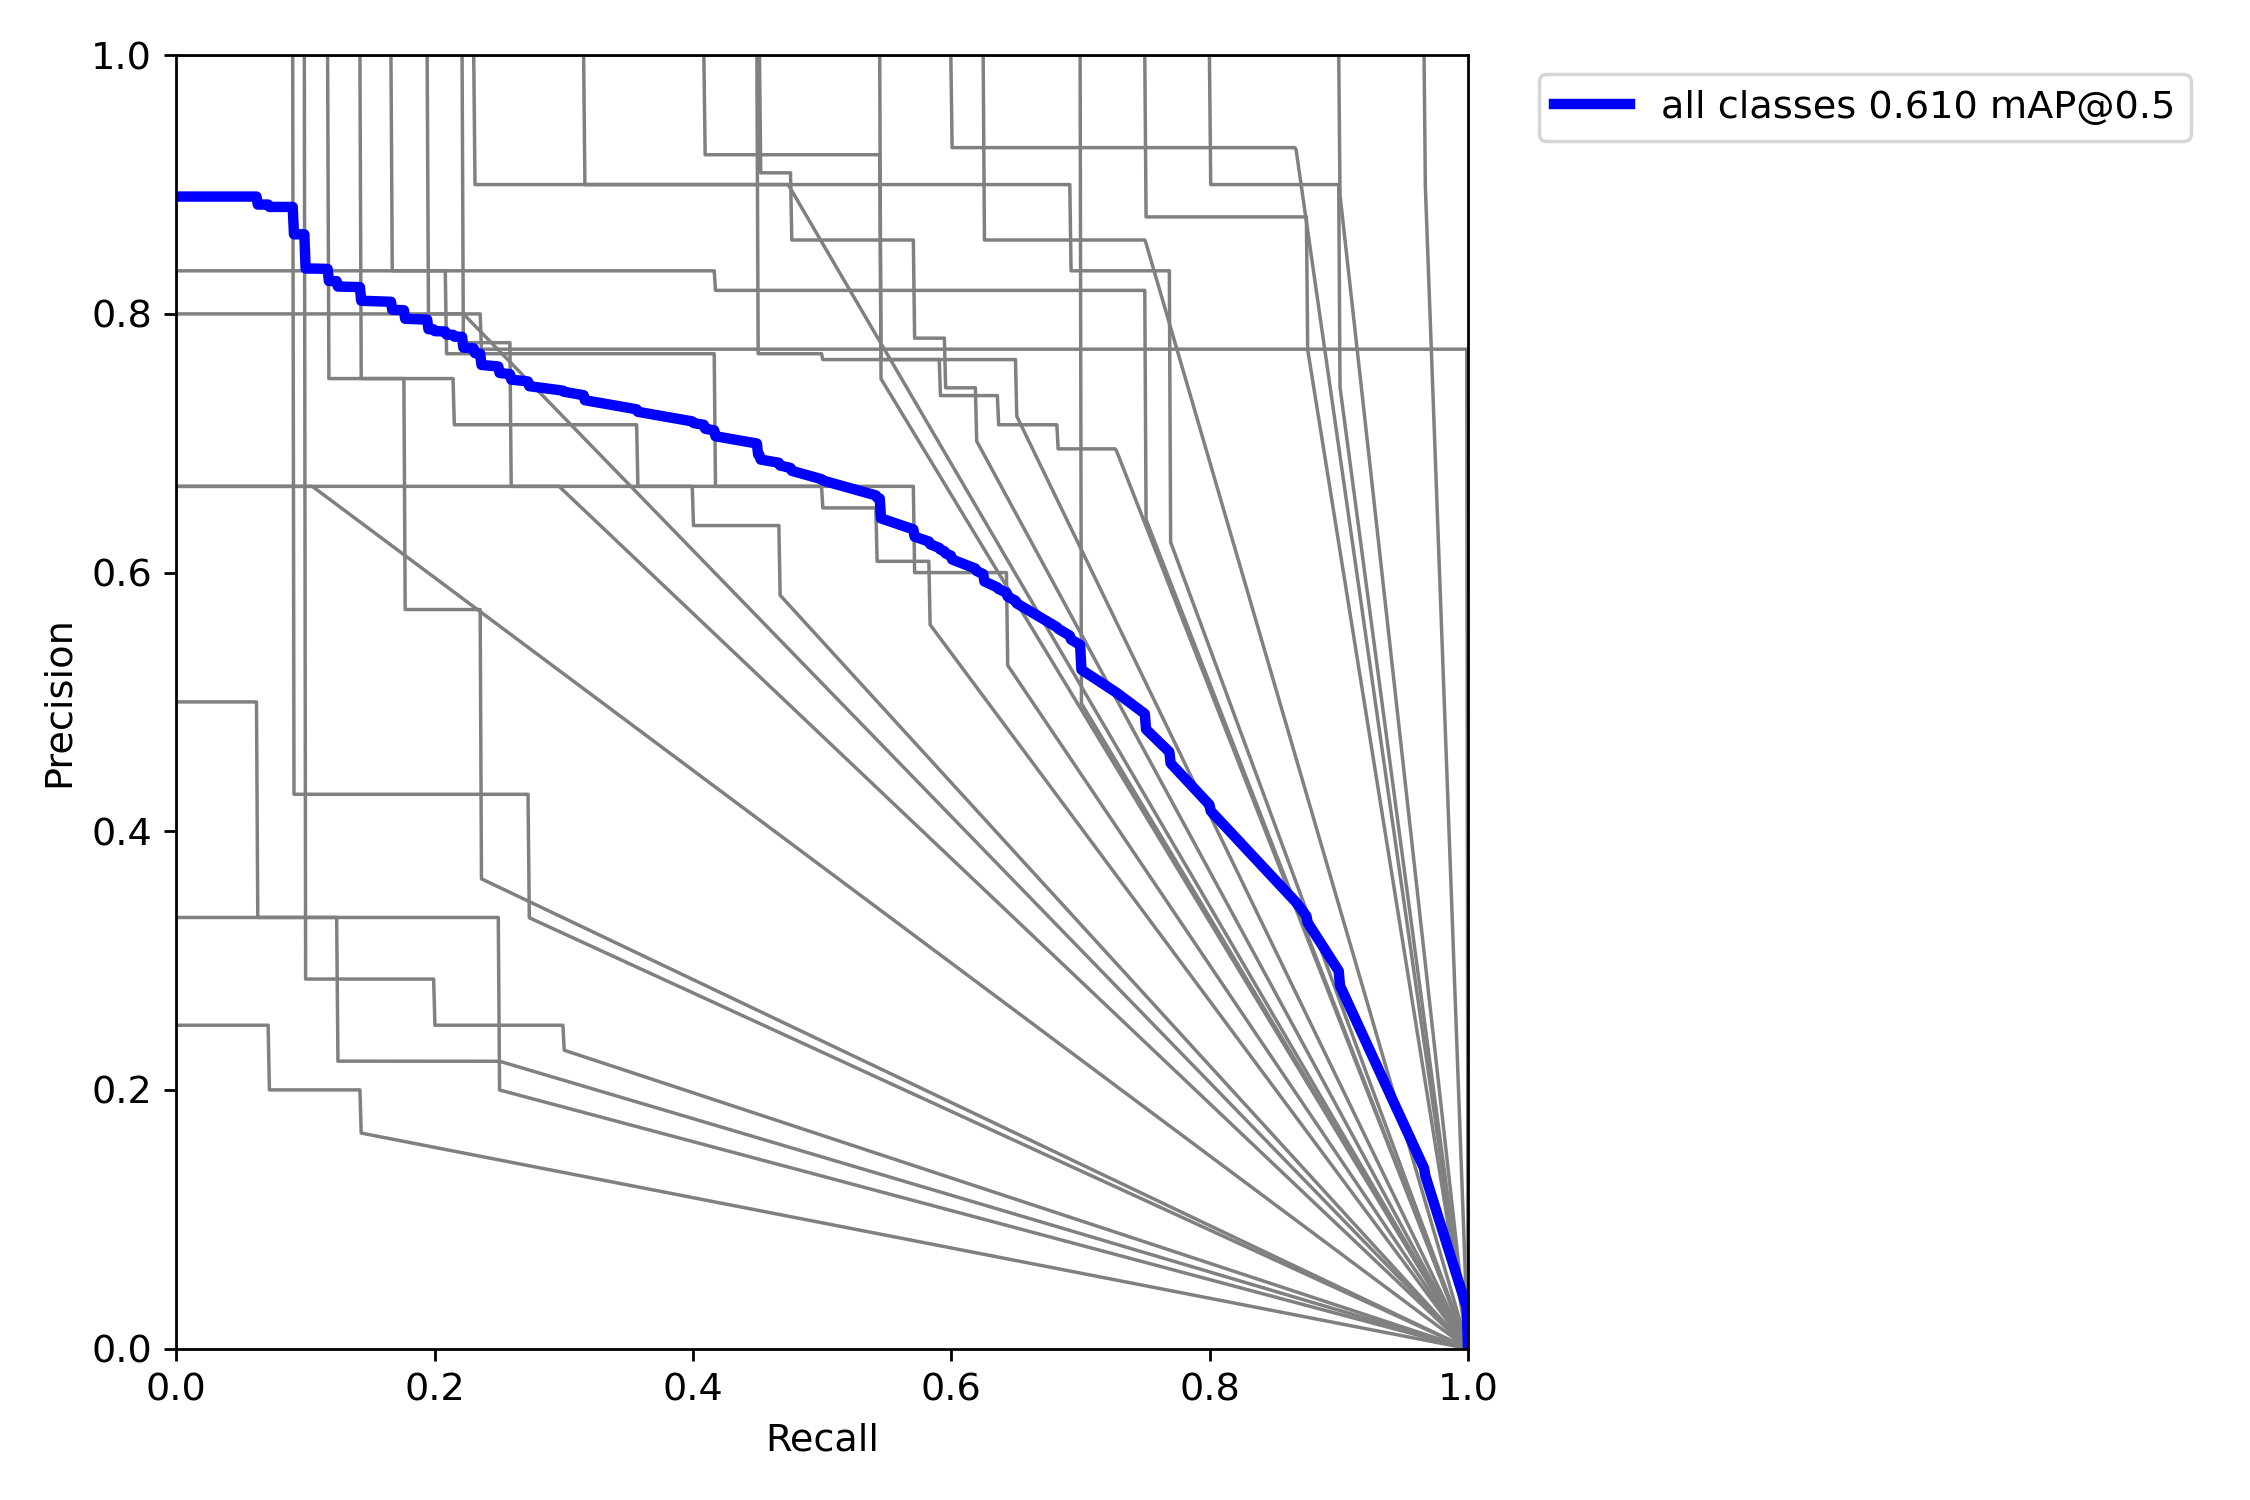

In [14]:
# F1 & PR curves
try:
    display.Image(filename='runs/val/'+get_last_exp('val')+'/F1_curve.png', width=600)
    display.Image(filename='runs/val/'+get_last_exp('val')+'/PR_curve.png', width=600)
except:
    print("Curves not found")  #probably need a not-too-bad model to generate curves?

## Confusion Matrix

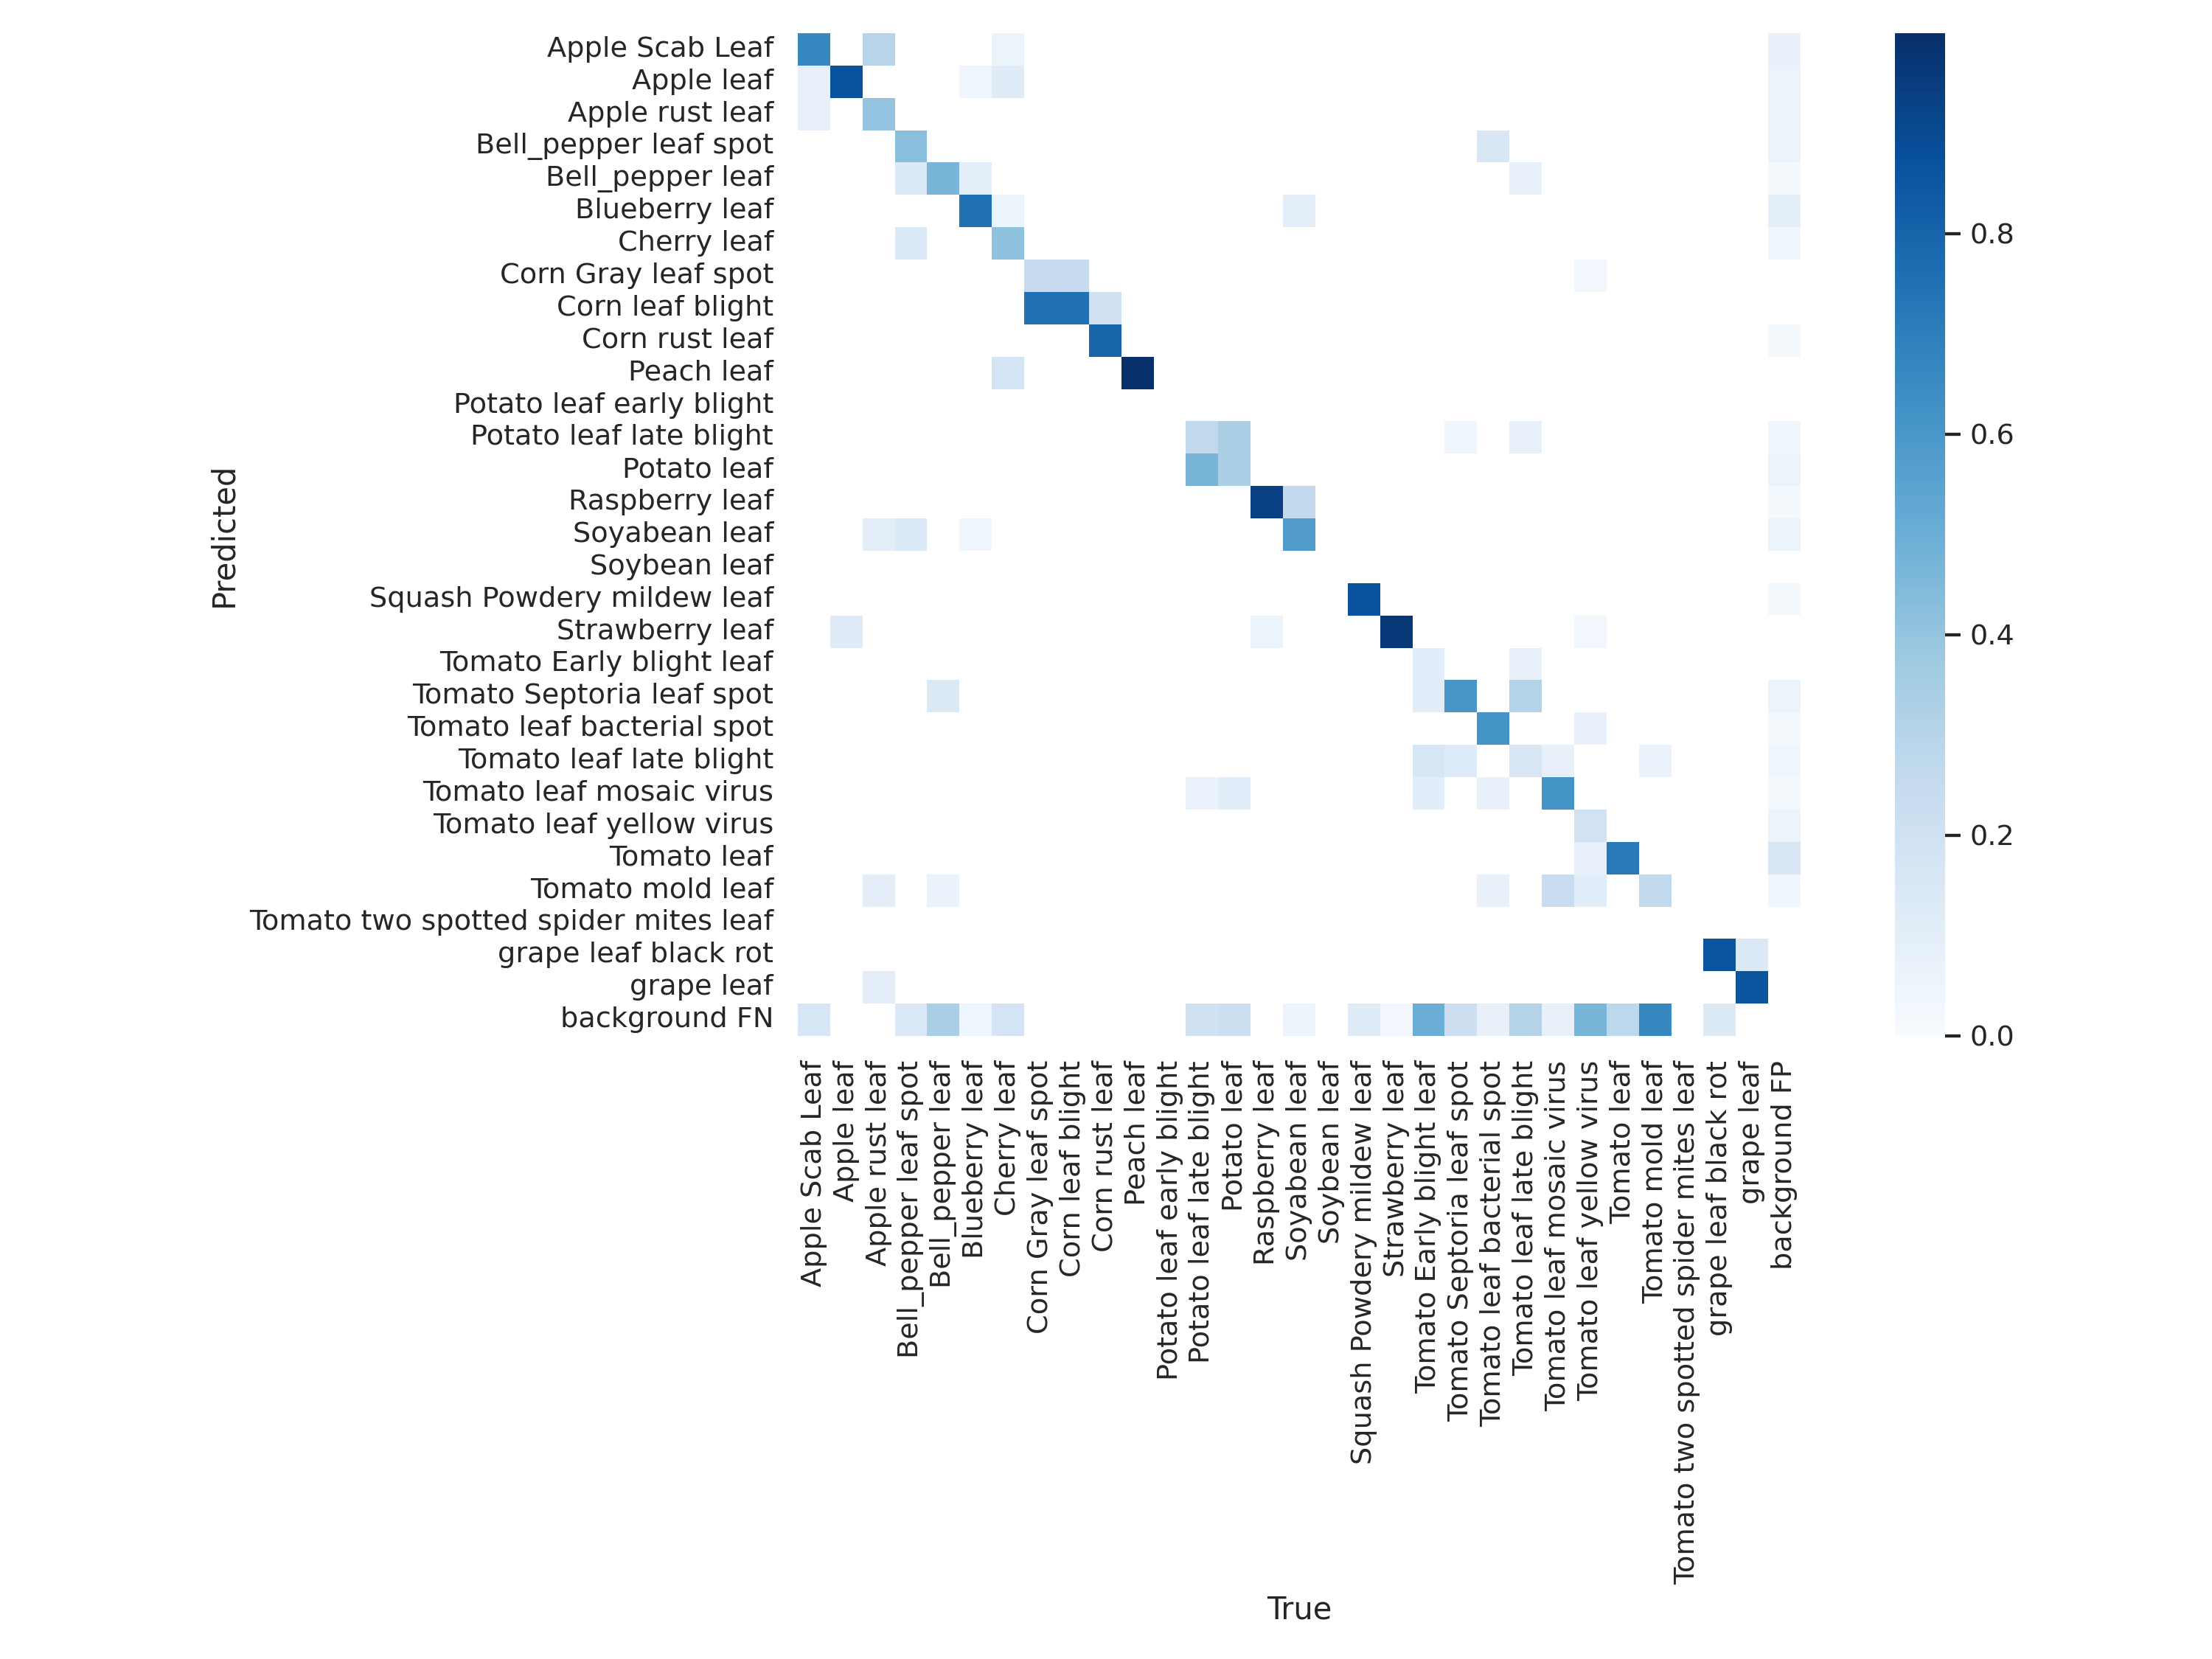

In [15]:
display.Image(filename='runs/val/'+get_last_exp('val')+'/confusion_matrix.png')

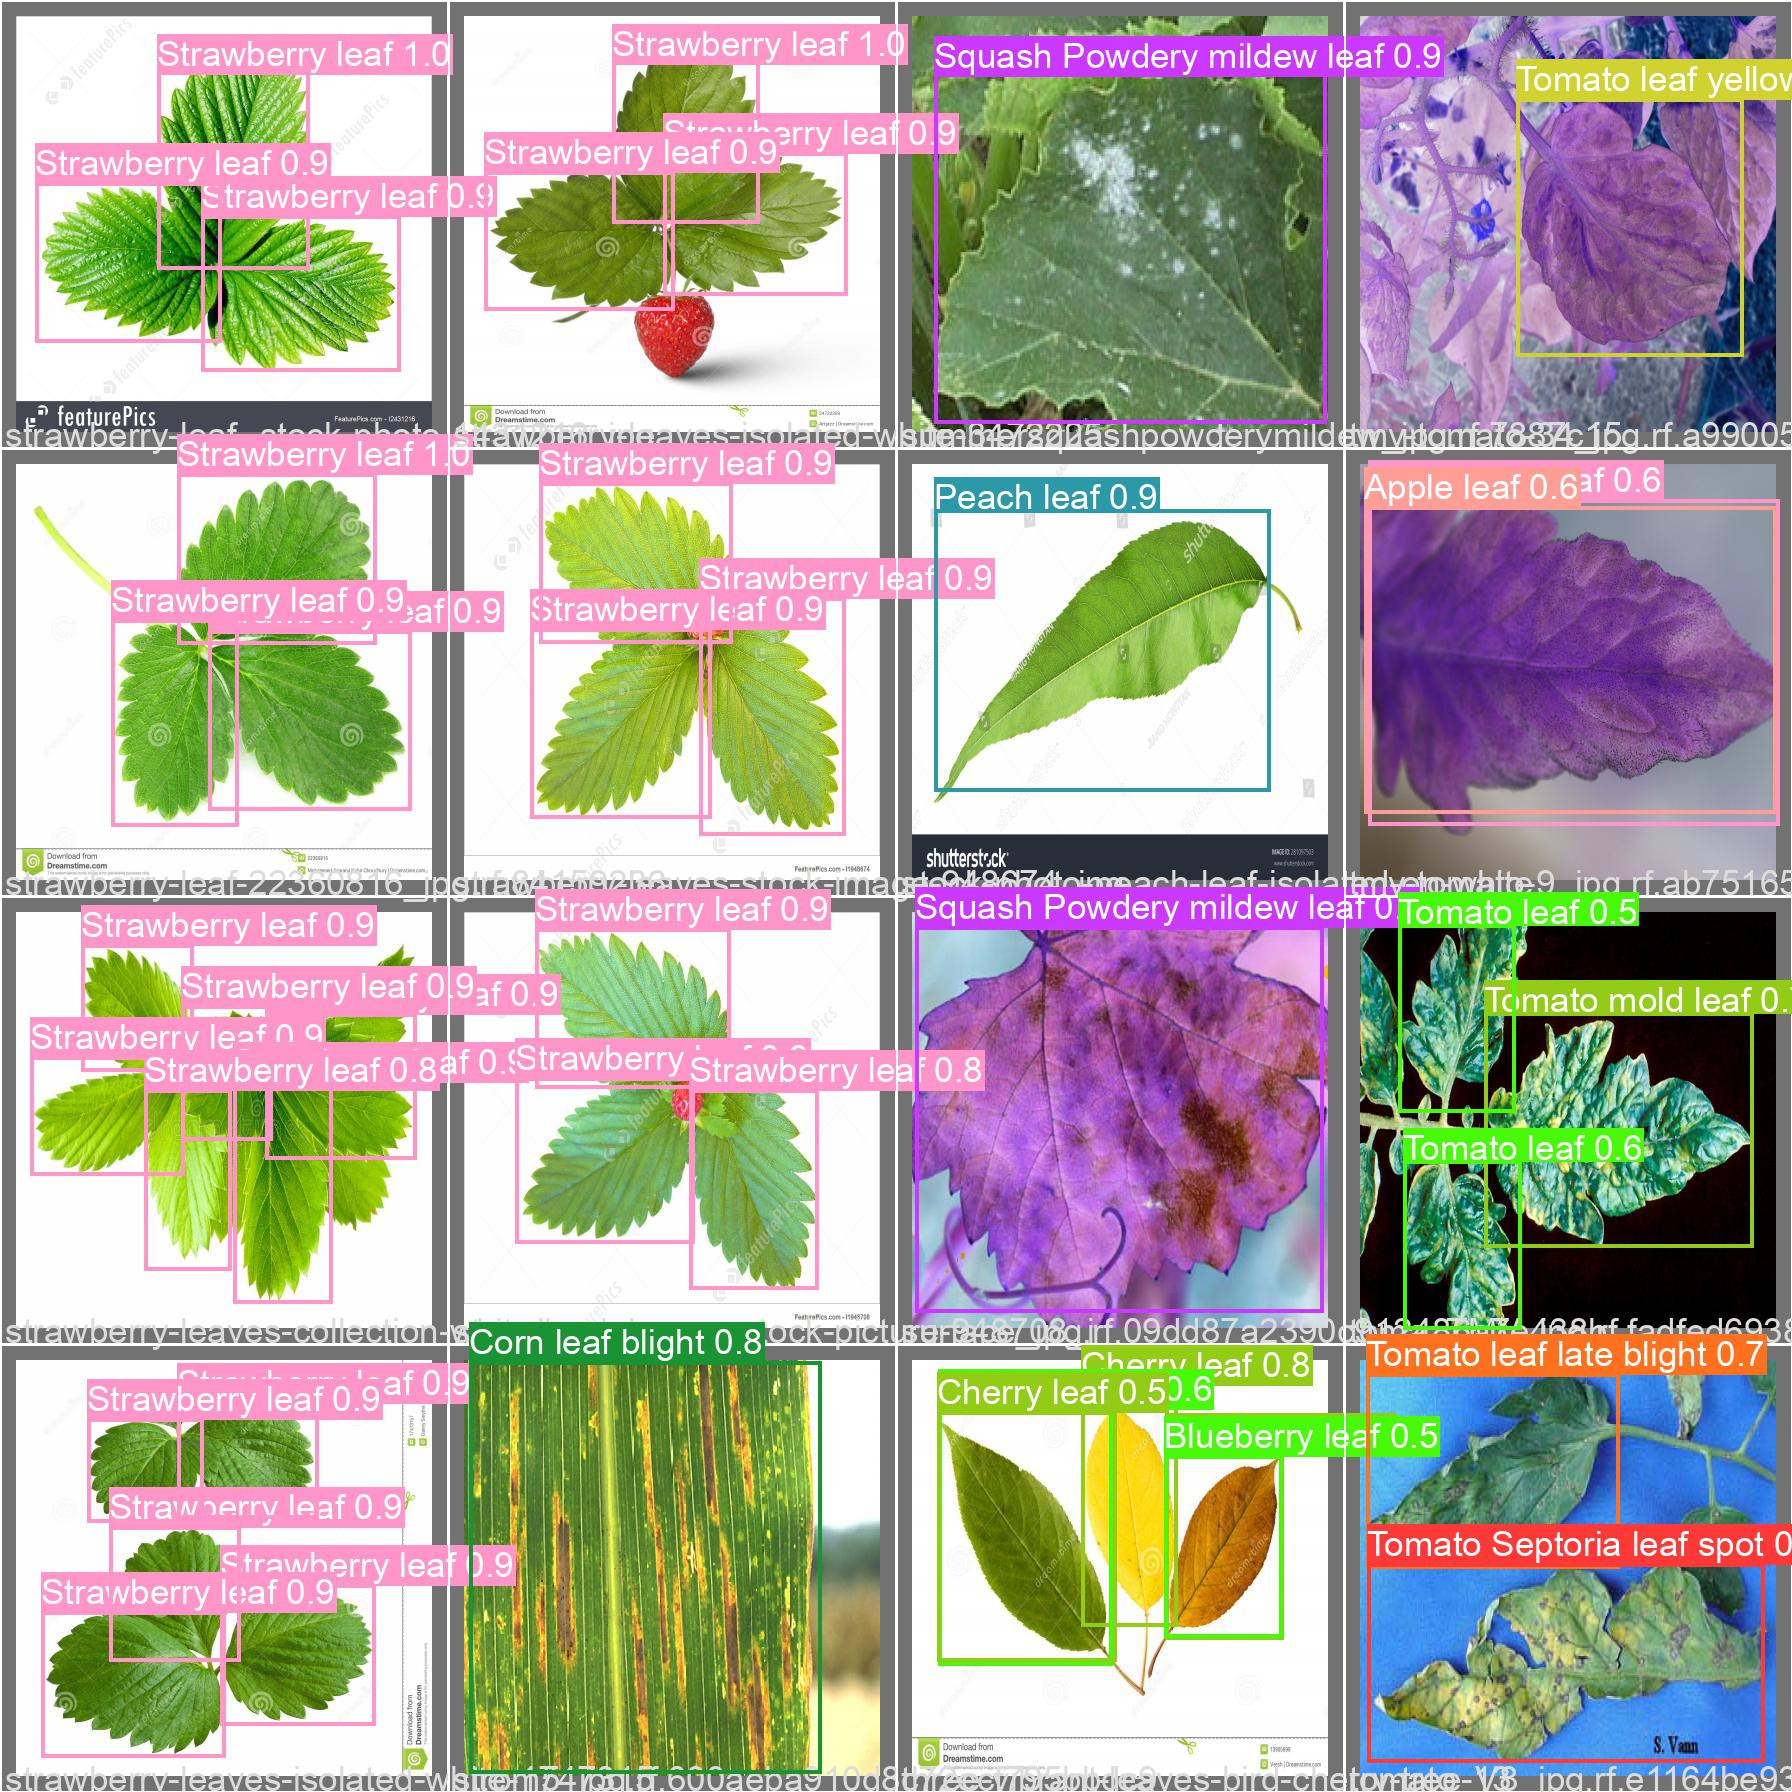

In [16]:
# a batch
display.Image(filename='runs/val/'+get_last_exp('val')+'/val_batch2_pred.jpg')

# 5. Inference 
detect

## Sample detection on one random image from validation set

Image n°183/239
Val Truth Object 0: Tomato mold leaf


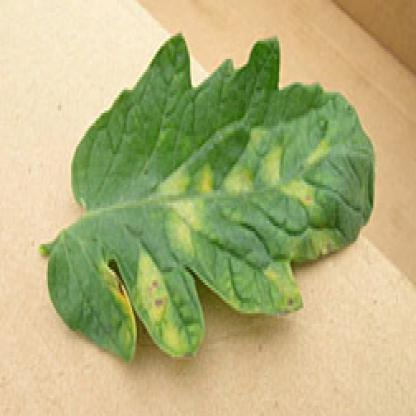

In [17]:
# choose a rondom image from validation set, print Truth, display image

from numpy.random import randint

# recup une image au hasard parmis set validation
val_images_path = '../valid/images'
len_val = len(os.listdir(val_images_path))
rnd_idx = randint(len_val)
print("Image n°{}/{}".format(rnd_idx, len_val))  #pour memoire au cas où elle serait remarquable
#rnd_idx = 2  ## pas random dans ce cas, mais un exemple joli
file = os.listdir(val_images_path)[rnd_idx]
file_path = val_images_path+'/'+file

# print Truth labels from val
label_path = '../valid/labels/'+file[:-4]+'.txt'
f = open(label_path, "r")
lines = f.read().split('\n')
for i, line in enumerate(lines):
    print('Val Truth Object {}: {}'.format(i,labels[int(line.split()[0])]))

#TODO: afficher les Truth bounding box pour pouvoir comparer visuellement avec la prédiction
# bbox = lsplit()[1:4]
# il faut la remettre à la bonne taille et import matplotlib (ou autre) pour l'afficher...

# display original image
display.Image(filename='../valid/images/'+file)

detect: weights=['runs/train/exp/weights/best.pt'], source=../valid/images/50%20Leafmold%20Top_jpg.rf.29a941a9c4a999749afc0a94a90b71dd.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-211-gfa2c16a torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7091035 parameters, 0 gradients, 16.1 GFLOPs
image 1/1 /kaggle/working/valid/images/50%20Leafmold%20Top_jpg.rf.29a941a9c4a999749afc0a94a90b71dd.jpg: 416x416 1 Tomato mold leaf, Done. (0.009s)
Speed: 0.4ms pre-process, 8.9ms inference, 1.8ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels
Ob

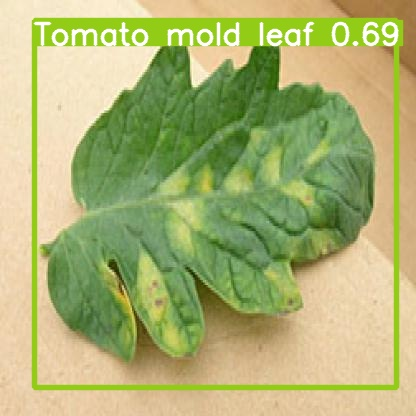

In [18]:
# detect
### confidence --conf should(??) be max from F1 curve
!python detect.py --weights {best_weights} --img {IMG_SIZE} --conf 0.4 --source {file_path} --save-txt --save-conf

# print prediction class & confidence
resfile_txt = 'runs/detect/'+get_last_exp('detect')+'/labels/'+file[:-4]+'.txt'
f = open(resfile_txt, "r")
lines = f.read().split('\n')
for i, line in enumerate(lines):
    lsplit = line.split()
    if len(lsplit)>5:
        print('Object {} - {} - Confidence: {}'.format(i,labels[int(lsplit[0])], lsplit[5]))

# display
display.Image(filename='runs/detect/'+get_last_exp('detect')+'/'+file)

In [19]:
## at the beginning, we change dir to yolov5. So if we run again the whole notebook without reset, we end with some imbricated mess... Please avoid !
!cd ..

# 6. References

## Yolo v5

<a align="left" href="https://ultralytics.com/yolov5" target="_blank">
<img width="1024", src="https://user-images.githubusercontent.com/26833433/125273437-35b3fc00-e30d-11eb-9079-46f313325424.png"></a>

This is a <em>fork</em> from the **official YOLOv5 🚀 notebook** by **Ultralytics**, freely available for redistribution under the [GPL-3.0 license](https://choosealicense.com/licenses/gpl-3.0/). 
For more information please visit https://github.com/ultralytics/yolov5 and https://ultralytics.com. Thank you!

## PlantDoc Dataset

The PlantDoc dataset was originally published by researchers at the Indian Institute of Technology, and described in depth in their paper. One of the paper’s authors, Pratik Kayal, shared the object detection dataset available on GitHub.

<img src="https://i.imgur.com/fGlQ0kG.png" width="300" height="200">

- Roboflow dataset: https://public.roboflow.com/object-detection/plantdoc
- Original dataset GitHub: https://github.com/pratikkayal/PlantDoc-Dataset
- arvix: https://arxiv.org/pdf/1911.10317.pdf

## Utility

Script to download from a WeTransfer link: https://github.com/iamleot/transferwee

Roboflow: https://roboflow.com

Weights & Biases: https://wandb.ai/site